In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
%matplotlib notebook

<IPython.core.display.Javascript object>


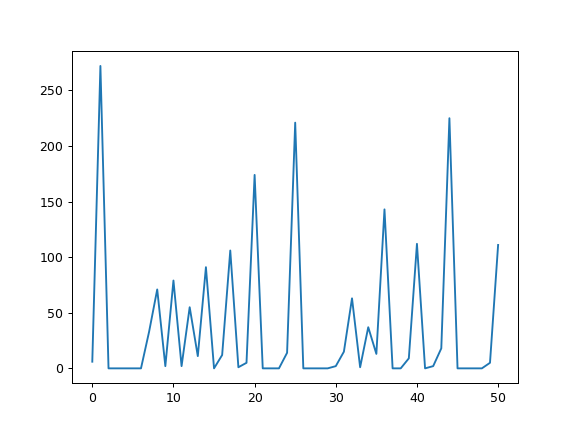

In [41]:
# simulator

def simulator(log_r, sigma, phi, n=50):
    N = [1]
    for t in range(1, n + 1):
        N_t = np.exp(log_r) * N[t-1] * np.exp(-N[t-1] + sigma * np.random.normal())
        N.append(N_t)
        
    N = np.array(N)
    y = np.random.poisson(phi * N)
    return y

plt.plot(range(51), simulator(3.8, 0.3, 10))